In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve,
    balanced_accuracy_score,
    log_loss
)

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

In [6]:
# -------------------- CONFIG --------------------
IMAGE_HEIGHT, IMAGE_WIDTH = 96, 96
SEQUENCE_LENGTH = 16
DATASET_DIR = "testing_data"
CLASSES_LIST = ["NonViolence", "Violence"]
MODEL_PATH = "../Weights/violence_detector.keras"

In [7]:
# -------------------- DATASET --------------------
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        frame = frame / 255.0
        frames_list.append(frame)

    video_reader.release()
    return frames_list


def create_test_dataset():
    features, labels = [], []
    for class_index, class_name in enumerate(CLASSES_LIST):
        class_dir = os.path.join(DATASET_DIR, class_name)
        for file in os.listdir(class_dir):
            video_path = os.path.join(class_dir, file)
            frames = frames_extraction(video_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)

    return np.asarray(features), np.array(labels)


Loading trained model...
Preparing test dataset...
Running inference...
13/13 [==============================] - 25s 2s/step

========== FINAL EVALUATION METRICS ==========
Confusion Matrix:
[[192   8]
 [  4 196]]

Accuracy            : 0.9700
Precision (Violence): 0.9608
Recall (Violence)   : 0.9800
F1-score (Violence) : 0.9703
ROC-AUC             : 0.9936
PR-AUC              : 0.9918


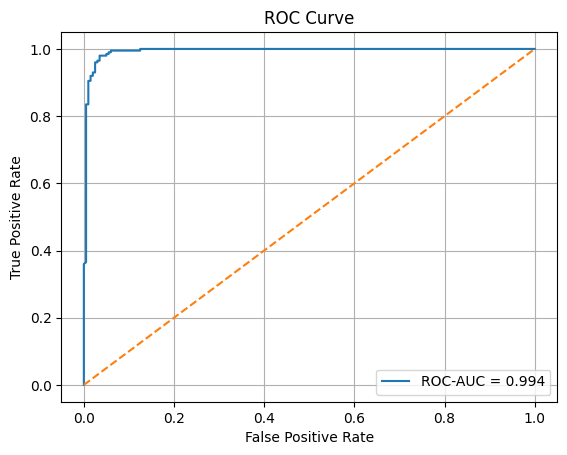

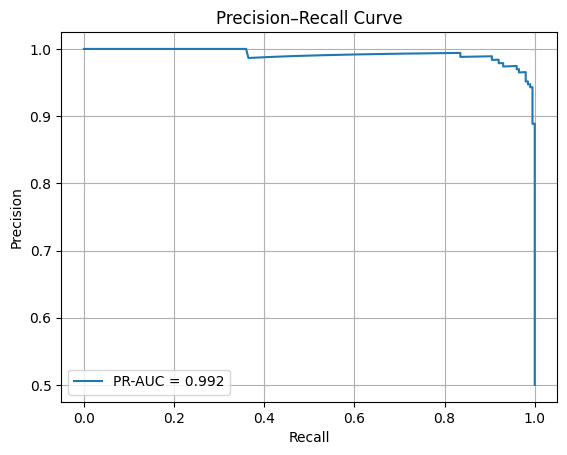

In [8]:
# -------------------- MAIN --------------------
if __name__ == "__main__":

    print("Loading trained model...")
    model = load_model(MODEL_PATH)

    print("Preparing test dataset...")
    X_test, y_test_labels = create_test_dataset()
    y_test = to_categorical(y_test_labels, num_classes=2)

    print("Running inference...")
    y_prob = model.predict(X_test)
    violence_probs = y_prob[:, 1]

    # Default threshold
    THRESHOLD = 0.5
    y_pred = (violence_probs >= THRESHOLD).astype(int)

    # -------------------- CONFUSION MATRIX --------------------
    cm = confusion_matrix(y_test_labels, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # -------------------- CORE METRICS --------------------
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    roc_auc = roc_auc_score(y_test_labels, violence_probs)
    pr_auc = average_precision_score(y_test_labels, violence_probs)

    print("\n========== FINAL EVALUATION METRICS ==========")
    print("Confusion Matrix:")
    print(cm)

    print(f"\nAccuracy            : {accuracy:.4f}")
    print(f"Precision (Violence): {precision:.4f}")
    print(f"Recall (Violence)   : {recall:.4f}")
    print(f"F1-score (Violence) : {f1:.4f}")
    print(f"ROC-AUC             : {roc_auc:.4f}")
    print(f"PR-AUC              : {pr_auc:.4f}")

    # -------------------- ROC CURVE --------------------
    fpr_curve, tpr_curve, _ = roc_curve(y_test_labels, violence_probs)

    plt.figure()
    plt.plot(fpr_curve, tpr_curve, label=f"ROC-AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # -------------------- PR CURVE --------------------
    precision_curve, recall_curve, _ = precision_recall_curve(
        y_test_labels, violence_probs
    )

    plt.figure()
    plt.plot(recall_curve, precision_curve, label=f"PR-AUC = {pr_auc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()
